In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

2024-06-14 09:33:49.372790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 09:33:49.396795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 09:33:50.020971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-14 09:33:50.781930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 09:33:50.824165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 09:33:50.824192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset/train/angry/im0.png')
print(f'\nImage size: {img.shape}')

Number of training images in each class:
angry: 3995 images
disgusted: 436 images
fearful: 4097 images
happy: 7215 images
sad: 4830 images
surprised: 3171 images
neutral: 4965 images

Number of test images in each class:
angry: 958 images
disgusted: 111 images
fearful: 1024 images
happy: 1774 images
sad: 1247 images
surprised: 831 images
neutral: 1233 images

Image size: (48, 48, 3)


In [3]:
# CNN MODEL
input_layer = tf.keras.layers.Input(shape=(48, 48, 3))

# Rescaling
x = tf.keras.layers.Rescaling(1./255)(input_layer)

# Erster konventioneller Convolutional Pfad
conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv1)
conv1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)

# Zweiter konventioneller Convolutional Pfad
conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(conv1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv2)
conv2 = tf.keras.layers.MaxPooling2D(2, 2)(conv2)

# Dritter konventioneller Convolutional Pfad
conv3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(conv2)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv3)
conv3 = tf.keras.layers.MaxPooling2D(2, 2)(conv3)

# Paralleler Pfad mit Dilated Convolutions
dilated1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', dilation_rate=2)(x)
dilated1 = tf.keras.layers.BatchNormalization()(dilated1)
dilated1 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated1)
dilated1 = tf.keras.layers.MaxPooling2D(2, 2)(dilated1)

dilated2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', dilation_rate=2)(dilated1)
dilated2 = tf.keras.layers.BatchNormalization()(dilated2)
dilated2 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated2)
dilated2 = tf.keras.layers.MaxPooling2D(2, 2)(dilated2)

dilated3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', dilation_rate=4)(dilated2)
dilated3 = tf.keras.layers.BatchNormalization()(dilated3)
dilated3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated3)
dilated3 = tf.keras.layers.MaxPooling2D(2, 2)(dilated3)

# Zusammenführung der Pfade
merged = tf.keras.layers.concatenate([conv3, dilated3])

# Flatten und Dense Layers
flat = tf.keras.layers.Flatten()(merged)
dense1 = tf.keras.layers.Dense(512)(flat)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dense1)
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(7, activation='softmax')(dropout)

# Modell definieren
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2024-06-14 09:33:51.127084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 09:33:51.127129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 09:33:51.127141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 09:33:51.200117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 09:33:51.200157: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 48, 48, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 24,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ leaky_re_lu_1[0]

 Total params: 10,188,551 (38.87 MB)

 Trainable params: 10,185,735 (38.86 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [7]:
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

# Anzahl der Klassen
num_classes = 7

# Prepare the data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Load and preprocess data
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [48, 48])
    return img

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def encode_label(label, label_lookup):
    label_id = label_lookup(label)
    depth = tf.cast(label_lookup.vocabulary_size(), tf.int32)
    return tf.one_hot(label_id, depth=depth)

def prepare_label_lookup(train_dir):
    file_paths = tf.data.Dataset.list_files(str(pathlib.Path(train_dir) / '*/*'), shuffle=False)
    labels = file_paths.map(lambda x: tf.strings.split(x, os.path.sep)[-2])
    label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
    label_lookup.adapt(labels)
    return label_lookup

label_lookup = prepare_label_lookup(train_dir)

def process_path(file_path, label_lookup):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = encode_label(label, label_lookup)
    return img, label

train_ds = tf.data.Dataset.list_files(str(pathlib.Path(train_dir) / '*/*.png'), shuffle=True)
train_ds = train_ds.map(lambda x: process_path(x, label_lookup), num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.list_files(str(pathlib.Path(test_dir) / '*/*.png'), shuffle=False)
test_ds = test_ds.map(lambda x: process_path(x, label_lookup), num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.shuffle(256).batch(32).prefetch(tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.shuffle(256).batch(32).prefetch(tf.data.experimental.AUTOTUNE).cache()



2024-06-14 09:37:31.647158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001, mode='max')


In [5]:
for image, label in train_ds.take(1):  # Nimm nur das erste Batch
    print(label)  # Zeigt die Labels des ersten Batches an

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]], shape=(32, 7), dtype=float32)


2024-06-14 09:34:22.307975: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-14 09:34:22.319164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.5665 - val_loss: 2.2226 - learning_rate: 1.0000e-05
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.5607 - val_loss: 2.2199 - learning_rate: 1.0000e-05
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.5652 - val_loss: 2.2058 - learning_rate: 1.0000e-05
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.5649 - val_loss: 2.2318 - learning_rate: 1.0000e-05
Epoch 5/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.5701 - val_loss: 2.2358 - learning_rate: 1.0000e-05
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.5683 - val_loss: 2.2484 - learning_rate: 1.0000e-05
Epoch 7/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - ac

In [13]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            img = cv2.resize(img, (48, 48))
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [14]:
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

print(x_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)

print(x_test)
print(y_test)

(7178, 48, 48, 3)
(7178,)
(7178, 7)
[[[[254 254 254]
   [254 254 254]
   [254 254 254]
   ...
   [ 16  16  16]
   [  0   0   0]
   [161 161 161]]

  [[254 254 254]
   [254 254 254]
   [254 254 254]
   ...
   [ 17  17  17]
   [  0   0   0]
   [122 122 122]]

  [[254 254 254]
   [254 254 254]
   [254 254 254]
   ...
   [ 26  26  26]
   [  0   0   0]
   [114 114 114]]

  ...

  [[ 66  66  66]
   [ 86  86  86]
   [ 99  99  99]
   ...
   [255 255 255]
   [252 252 252]
   [254 254 254]]

  [[ 84  84  84]
   [ 92  92  92]
   [ 92  92  92]
   ...
   [236 236 236]
   [255 255 255]
   [255 255 255]]

  [[ 93  93  93]
   [ 90  90  90]
   [ 85  85  85]
   ...
   [ 42  42  42]
   [129 129 129]
   [180 180 180]]]


 [[[176 176 176]
   [177 177 177]
   [170 170 170]
   ...
   [ 94  94  94]
   [ 87  87  87]
   [108 108 108]]

  [[181 181 181]
   [180 180 180]
   [180 180 180]
   ...
   [ 98  98  98]
   [ 89  89  89]
   [ 97  97  97]]

  [[178 178 178]
   [182 182 182]
   [187 187 187]
   ...
   [ 95  

Model loaded from emotion_recognition_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1234 - loss: 10.2155
[9.992802619934082, 0.1529673933982849]
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.10      0.07       958
           1       0.01      0.06      0.01       111
           2       0.15      0.18      0.16      1024
           3       0.07      0.03      0.05      1774
           4       0.17      0.13      0.15      1247
           5       0.74      0.70      0.72       831
           6       0.03      0.00      0.00      1233

    accuracy                           0.15      7178
   macro avg       0.17      0.17      0.17      7178
weighted avg       0.17      0.15      0.15      7178

Confusion Matrix:
 [[  99  142  144  105  427   36    5]
 [   9    7    8    8   24    3   52]
 [  81  139  181  404  136   82    1]
 [1363  123  124   60   76   28    0]
 [ 1

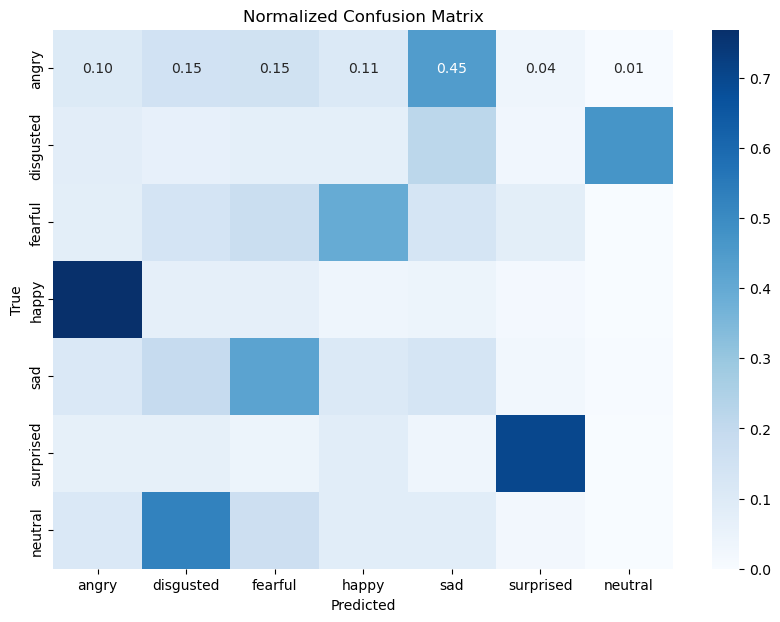

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Predicted emotion: happy


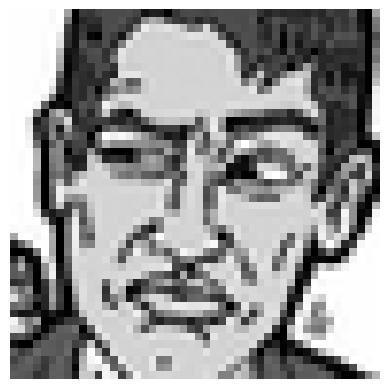

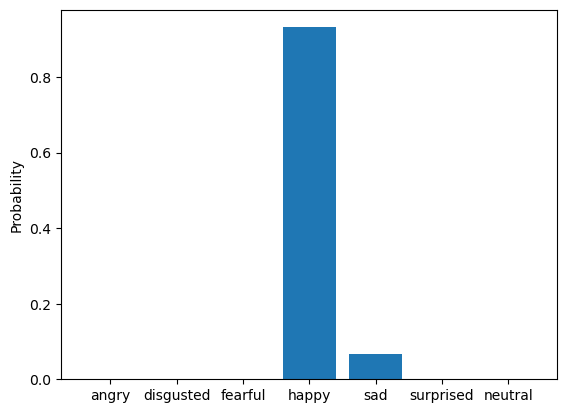

In [16]:
history = None

if history is not None:

    # PLOT TRAINING AND VALIDATION ACCURACY
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # PLOT TRAINING AND VALIDATION LOSS
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Zugreifen auf die Metriken im Trainingsverlauf
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    # Beispielausgabe der Genauigkeit
    print("Training Accuracy:", accuracy)
    print("Validation Accuracy:", val_accuracy)


# SAVE MODEL, if model is defined
model = None

if model is not None: 
    model.save('emotion_recognition_model.h5')
    print('Model saved as emotion_recognition_model.h5')
else:
    # Load model
    model = tf.keras.models.load_model('emotion_recognition_model.h5')
    print('Model loaded from emotion_recognition_model.h5')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
# Evaluiere das Modell
evaluation = model.evaluate(x_test, y_test_encoded)

# Evaluationsergebnisse anzeigen
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# TEST MODEL


# Load test image
img = cv2.imread('dataset/test/angry/im0.png')
img = cv2.resize(img, (48, 48))
img = np.reshape(img, [1, 48, 48, 3])

# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f'Predicted emotion: {emotion}')

# Display image
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel('Probability')
plt.show()